In [1]:
# Import libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import tkinter as tk
from tkinter import Label, Button, filedialog
from PIL import Image, ImageTk
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


c:\Users\bhata\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\bhata\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\bhata\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framewo

In [2]:
# Constants
IMG_HEIGHT, IMG_WIDTH = 128, 128  # Keep consistent everywhere
BATCH_SIZE = 16
EPOCHS = 20

# Dataset paths (update if needed)
TRAIN_DIR = r"C:\Users\bhata\Desktop\training_set"
TEST_DIR = r"C:\Users\bhata\Desktop\test_set"

In [3]:
# Define model creation function
def create_model():
    base_model = VGG16(weights="imagenet", include_top=False,
                       input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    for layer in base_model.layers:
        layer.trainable = False  # Freeze backbone

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(1, activation="sigmoid")  # Binary
    ])

    model.compile(optimizer=Adam(1e-4),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

In [4]:
# Create and summarize model
model = create_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,763,521 (60.13 MB)

 Trainable params: 1,048,833 (4.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [5]:
# Set up data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Important for confusion matrix
)

# Verify data setup
print("Class indices:", train_generator.class_indices)
print(f"Training samples: {train_generator.n}")
print(f"Test samples: {val_generator.n}")

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Class indices: {'cats': 0, 'dogs': 1}
Training samples: 8000
Test samples: 2000


In [6]:
# Define callbacks and train model
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "cat_dog_best.h5", save_best_only=True
    )
]

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks
)

# Save model
model.save("cat_dog_model.h5")
print("Saved: cat_dog_model.h5")

c:\Users\bhata\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.7105 - loss: 0.5633

500/500 ━━━━━━━━━━━━━━━━━━━━ 272s 543ms/step - accuracy: 0.7106 - loss: 0.5632 - val_accuracy: 0.8635 - val_loss: 0.3181
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.8198 - loss: 0.3973

500/500 ━━━━━━━━━━━━━━━━━━━━ 208s 416ms/step - accuracy: 0.8199 - loss: 0.3973 - val_accuracy: 0.8750 - val_loss: 0.2910
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.8280 - loss: 0.3733

500/500 ━━━━━━━━━━━━━━━━━━━━ 220s 440ms/step - accuracy: 0.8280 - loss: 0.3733 - val_accuracy: 0.8730 - val_loss: 0.2905
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.8448 - loss: 0.3541

500/500 ━━━━━━━━━━━━━━━━━━━━ 205s 409ms/step - accuracy: 0.8448 - loss: 0.3541 - val_accuracy: 0.8820 - val_loss: 0.2734
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.8393 - loss: 0.3517

500/500 ━━━━━━━━━━━━━━━━━━━━ 204s 407ms/step - accuracy: 0.8393 - loss: 0.3517 - val_accuracy: 0.8770 - val_loss: 0.2712
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 202s 403ms/step - accuracy: 0.8431 - loss: 0.3530 - val_accuracy: 0.8800 - val_loss: 0.2770
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.8590 - loss: 0.3312

500/500 ━━━━━━━━━━━━━━━━━━━━ 214s 428ms/step - accuracy: 0.8590 - loss: 0.3312 - val_accuracy: 0.8875 - val_loss: 0.2625
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.8518 - loss: 0.3277

500/500 ━━━━━━━━━━━━━━━━━━━━ 215s 430ms/step - accuracy: 0.8518 - loss: 0.3277 - val_accuracy: 0.8870 - val_loss: 0.2589
Epoch 9/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.8501 - loss: 0.3235

500/500 ━━━━━━━━━━━━━━━━━━━━ 216s 432ms/step - accuracy: 0.8501 - loss: 0.3235 - val_accuracy: 0.8930 - val_loss: 0.2538
Epoch 10/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 214s 427ms/step - accuracy: 0.8564 - loss: 0.3259 - val_accuracy: 0.8895 - val_loss: 0.2541
Epoch 11/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.8514 - loss: 0.3155

500/500 ━━━━━━━━━━━━━━━━━━━━ 217s 433ms/step - accuracy: 0.8514 - loss: 0.3155 - val_accuracy: 0.8930 - val_loss: 0.2487
Epoch 12/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 204s 407ms/step - accuracy: 0.8629 - loss: 0.3171 - val_accuracy: 0.8815 - val_loss: 0.2705
Epoch 13/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 214s 429ms/step - accuracy: 0.8549 - loss: 0.3212 - val_accuracy: 0.8885 - val_loss: 0.2492
Epoch 14/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.8611 - loss: 0.3096

500/500 ━━━━━━━━━━━━━━━━━━━━ 214s 428ms/step - accuracy: 0.8611 - loss: 0.3096 - val_accuracy: 0.8865 - val_loss: 0.2448
Epoch 15/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 213s 427ms/step - accuracy: 0.8656 - loss: 0.3036 - val_accuracy: 0.8735 - val_loss: 0.2818
Epoch 16/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 212s 425ms/step - accuracy: 0.8662 - loss: 0.3000 - val_accuracy: 0.8935 - val_loss: 0.2463
Epoch 17/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 214s 428ms/step - accuracy: 0.8588 - loss: 0.3140 - val_accuracy: 0.8945 - val_loss: 0.2467
Epoch 18/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 214s 428ms/step - accuracy: 0.8622 - loss: 0.3070 - val_accuracy: 0.8910 - val_loss: 0.2544
Epoch 19/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 254s 508ms/step - accuracy: 0.8658 - loss: 0.3012 - val_accuracy: 0.8860 - val_loss: 0.2582


Saved: cat_dog_model.h5


In [7]:
# Define evaluation function
def evaluate_model(model, generator, name="Model"):
    try:
        # Reset generator
        generator.reset()
        total_samples = generator.n
        print(f"Evaluating {name} on {total_samples} images...")
        
        if total_samples == 0:
            raise ValueError("Generator has no samples. Check TEST_DIR or TRAIN_DIR paths and subfolders.")

        predictions = []
        true_labels = []
        for i in range(len(generator)):
            try:
                x_batch, y_batch = next(generator)
                print(f"Batch {i+1}: {x_batch.shape} images, {y_batch.shape} labels")
                y_pred = model.predict(x_batch, verbose=0)
                y_pred_binary = (y_pred > 0.5).astype(int).flatten()
                predictions.extend(y_pred_binary)
                true_labels.extend(y_batch.astype(int))
            except Exception as e:
                print(f"Error processing batch {i+1}: {e}")
                continue
        
        # Truncate to ensure equal lengths
        min_length = min(len(predictions), len(true_labels))
        if min_length == 0:
            raise ValueError("No valid predictions or labels collected. Check generator or model.")
        predictions = predictions[:min_length]
        true_labels = true_labels[:min_length]
        
        # Compute confusion matrix
        cm = confusion_matrix(true_labels, predictions)
        
        # Print evaluation metrics
        loss, accuracy = model.evaluate(generator, verbose=0)
        print(f"{name} Loss: {loss:.4f}")
        print(f"{name} Accuracy: {accuracy:.4f}")
        
        # Plot confusion matrix
        class_names = ["Cat", "Dog"] if generator.class_indices.get("cats", 0) == 0 else ["Dog", "Cat"]
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                    xticklabels=class_names, yticklabels=class_names)
        plt.title(f"{name} Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()
        
        return cm, accuracy
    
    except Exception as e:
        print(f"Error in evaluate_model ({name}): {e}")
        return None, None

Evaluating saved models...


Loaded model: cat_dog_model.h5
Evaluating Test (cat_dog_model.h5) on 2000 images...
Batch 1: (16, 128, 128, 3) images, (16,) labels
Batch 2: (16, 128, 128, 3) images, (16,) labels
Batch 3: (16, 128, 128, 3) images, (16,) labels
Batch 4: (16, 128, 128, 3) images, (16,) labels
Batch 5: (16, 128, 128, 3) images, (16,) labels
Batch 6: (16, 128, 128, 3) images, (16,) labels
Batch 7: (16, 128, 128, 3) images, (16,) labels
Batch 8: (16, 128, 128, 3) images, (16,) labels
Batch 9: (16, 128, 128, 3) images, (16,) labels
Batch 10: (16, 128, 128, 3) images, (16,) labels
Batch 11: (16, 128, 128, 3) images, (16,) labels
Batch 12: (16, 128, 128, 3) images, (16,) labels
Batch 13: (16, 128, 128, 3) images, (16,) labels
Batch 14: (16, 128, 128, 3) images, (16,) labels
Batch 15: (16, 128, 128, 3) images, (16,) labels
Batch 16: (16, 128, 128, 3) images, (16,) labels
Batch 17: (16, 128, 128, 3) images, (16,) labels
Batch 18: (16, 128, 128, 3) images, (16,) labels
Batch 19: (16, 128, 128, 3) images, (16,) l

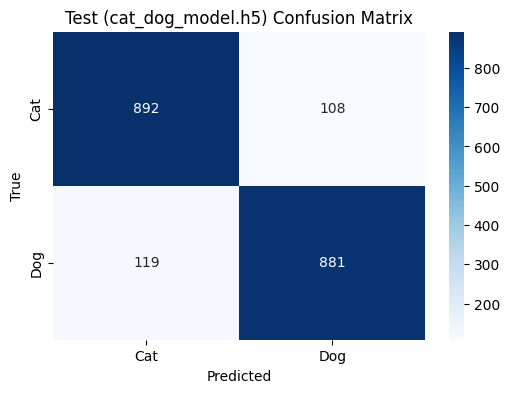

Found 8000 images belonging to 2 classes.
Evaluating Train (cat_dog_model.h5) on 8000 images...
Batch 1: (16, 128, 128, 3) images, (16,) labels
Batch 2: (16, 128, 128, 3) images, (16,) labels
Batch 3: (16, 128, 128, 3) images, (16,) labels
Batch 4: (16, 128, 128, 3) images, (16,) labels
Batch 5: (16, 128, 128, 3) images, (16,) labels
Batch 6: (16, 128, 128, 3) images, (16,) labels
Batch 7: (16, 128, 128, 3) images, (16,) labels
Batch 8: (16, 128, 128, 3) images, (16,) labels
Batch 9: (16, 128, 128, 3) images, (16,) labels
Batch 10: (16, 128, 128, 3) images, (16,) labels
Batch 11: (16, 128, 128, 3) images, (16,) labels
Batch 12: (16, 128, 128, 3) images, (16,) labels
Batch 13: (16, 128, 128, 3) images, (16,) labels
Batch 14: (16, 128, 128, 3) images, (16,) labels
Batch 15: (16, 128, 128, 3) images, (16,) labels
Batch 16: (16, 128, 128, 3) images, (16,) labels
Batch 17: (16, 128, 128, 3) images, (16,) labels
Batch 18: (16, 128, 128, 3) images, (16,) labels
Batch 19: (16, 128, 128, 3) ima

c:\Users\bhata\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Train (cat_dog_model.h5) Loss: 0.2101
Train (cat_dog_model.h5) Accuracy: 0.9149


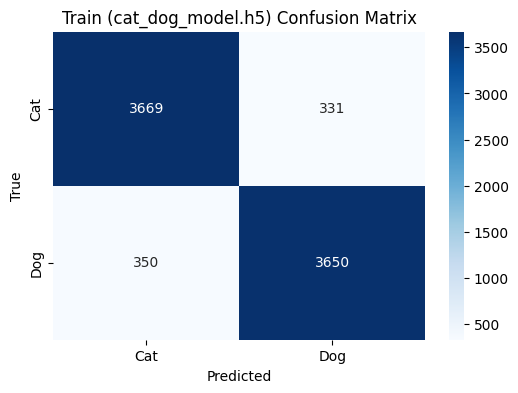

Loaded best model: cat_dog_best.h5
Evaluating Test (cat_dog_best.h5) on 2000 images...
Batch 1: (16, 128, 128, 3) images, (16,) labels
Batch 2: (16, 128, 128, 3) images, (16,) labels
Batch 3: (16, 128, 128, 3) images, (16,) labels
Batch 4: (16, 128, 128, 3) images, (16,) labels
Batch 5: (16, 128, 128, 3) images, (16,) labels
Batch 6: (16, 128, 128, 3) images, (16,) labels
Batch 7: (16, 128, 128, 3) images, (16,) labels
Batch 8: (16, 128, 128, 3) images, (16,) labels
Batch 9: (16, 128, 128, 3) images, (16,) labels
Batch 10: (16, 128, 128, 3) images, (16,) labels
Batch 11: (16, 128, 128, 3) images, (16,) labels
Batch 12: (16, 128, 128, 3) images, (16,) labels
Batch 13: (16, 128, 128, 3) images, (16,) labels
Batch 14: (16, 128, 128, 3) images, (16,) labels
Batch 15: (16, 128, 128, 3) images, (16,) labels
Batch 16: (16, 128, 128, 3) images, (16,) labels
Batch 17: (16, 128, 128, 3) images, (16,) labels
Batch 18: (16, 128, 128, 3) images, (16,) labels
Batch 19: (16, 128, 128, 3) images, (16,

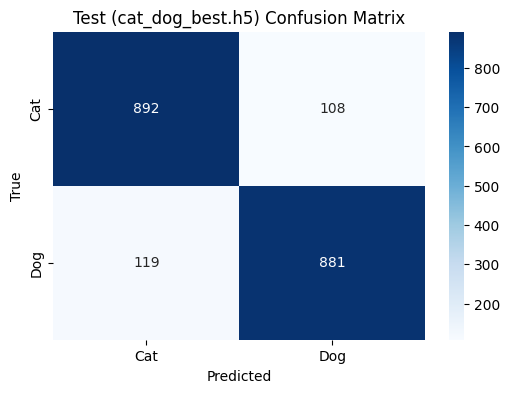

In [8]:
# Evaluate saved models
print("Evaluating saved models...")

# Check if val_generator is defined
if 'val_generator' not in globals():
    print("Error: val_generator not defined. Run Cell 5 to set up data generators.")
else:
    # Load model (try .keras first, fallback to .h5)
    model_file = "cat_dog_model.keras" if os.path.exists("cat_dog_model.keras") else "cat_dog_model.h5"
    try:
        loaded_model = tf.keras.models.load_model(model_file)
        print(f"Loaded model: {model_file}")
        evaluate_model(loaded_model, val_generator, f"Test ({model_file})")
    except Exception as e:
        print(f"Error loading {model_file}: {e}")

    # Evaluate on training set to check for underfitting
    try:
        train_generator_eval = test_datagen.flow_from_directory(
            TRAIN_DIR,
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            batch_size=BATCH_SIZE,
            class_mode='binary',
            shuffle=False
        )
        evaluate_model(loaded_model, train_generator_eval, f"Train ({model_file})")
    except Exception as e:
        print(f"Error setting up train_generator_eval: {e}")

    # Evaluate best model if available
    best_model_file = "cat_dog_best.keras" if os.path.exists("cat_dog_best.keras") else "cat_dog_best.h5"
    if os.path.exists(best_model_file):
        try:
            loaded_best_model = tf.keras.models.load_model(best_model_file)
            print(f"Loaded best model: {best_model_file}")
            evaluate_model(loaded_best_model, val_generator, f"Test ({best_model_file})")
        except Exception as e:
            print(f"Error loading {best_model_file}: {e}")
    else:
        print(f"Best model ({best_model_file}) not found.")

In [9]:
# Define GUI class
class CatDogApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Cat vs Dog Classifier")

        # Load best model if available
        model_file = "cat_dog_best.h5" if os.path.exists("cat_dog_best.h5") else "cat_dog_model.h5"
        self.model = tf.keras.models.load_model(model_file)
        print(f"GUI using model: {model_file}")

        # UI elements
        self.label = Label(root, text="Upload an image to classify", font=("Arial", 14))
        self.label.pack(pady=10)

        self.upload_btn = Button(root, text="Upload Image", command=self.upload_image)
        self.upload_btn.pack(pady=5)

        self.image_label = Label(root)
        self.image_label.pack(pady=10)

        self.result_label = Label(root, text="", font=("Arial", 16, "bold"))
        self.result_label.pack(pady=10)

    def upload_image(self):
        file_path = filedialog.askopenfilename(
            filetypes=[("Image files", "*.jpg *.jpeg *.png")]
        )
        if not file_path:
            return

        # Show uploaded image
        img = Image.open(file_path)
        img_resized = img.resize((200, 200))  # Display size
        tk_img = ImageTk.PhotoImage(img_resized)
        self.image_label.configure(image=tk_img)
        self.image_label.image = tk_img

        # Predict
        self.predict_image(file_path)

    def predict_image(self, file_path):
        img = load_img(file_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        prediction = self.model.predict(img_array)[0][0]

        # Confidence threshold logic (increased to 0.85 for stricter OOD detection)
        threshold = 0.85
        if prediction < (1 - threshold):
            result = f"Prediction: 🐱 Cat ({(1 - prediction) * 100:.2f}%)"
        elif prediction > threshold:
            result = f"Prediction: 🐶 Dog ({prediction * 100:.2f}%)"
        else:
            result = "Prediction: ❌ Unknown — image not recognized as cat or dog"

        self.result_label.config(text=result)

In [ ]:
if __name__ == "__main__":
    root = tk.Tk()
    app = CatDogApp(root)
    root.mainloop()

GUI using model: cat_dog_best.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
